In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import seaborn as sns
from sklearn.decomposition import PCA
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification


#Regression

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,ExtraTreesRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split,cross_val_score, cross_validate
from sklearn.metrics import median_absolute_error, mean_squared_error





# carrega o dataset
dataset = pd.read_csv('./solicitacoescredito.csv')

#print(dataset.head())

# periodoDemonstrativoEmMeses -> converte valores nulos ou 0 em 1
dataset['periodoDemonstrativoEmMeses'] = dataset['periodoDemonstrativoEmMeses'].replace(np.nan, 1)
dataset['periodoDemonstrativoEmMeses'] = dataset['periodoDemonstrativoEmMeses'].replace(0, 1)

# faturamentoBruto -> converte valores nulos em 0 
dataset['faturamentoBruto'] = dataset['faturamentoBruto'].replace(np.nan, 0)
dataset['faturamentoBruto'] = dataset['faturamentoBruto'] / dataset['periodoDemonstrativoEmMeses']
dataset['mergemBruta'] = dataset['margemBruta'] / dataset['periodoDemonstrativoEmMeses']
dataset['percentualProtestos'] = dataset['percentualProtestos'].replace(np.nan, 0)
dataset.dropna(subset=['margemBruta'], inplace=True)
dataset=dataset.loc[dataset['valorAprovado']>0]
dataset=dataset.loc[dataset['valorSolicitado']<30000]


# numero_solicitacao                                                    # irrelevante
# razaoSocial                                                           # irrelevante
# nomeFantasia                                                          # irrelevante
# cnpjSemTraco                                                          # irrelevante
# maiorAtraso                                                           # informação não existe na primeira compra
# margemBrutaAcumulada                                                  # informação não existe na primeira compra
# percentualProtestos = dataset['percentualProtestos']                  # ######## ver tratamento (abaixo)
# primeiraCompra                                                        # informação não existe na primeira compra
# prazoMedioRecebimentoVendas                                           # informação não existe na primeira compra
# titulosEmAberto = dataset['titulosEmAberto']                          # ok
# valorSolicitado                                                       # irrelevante
# status                                                                # informação não existe na primeira compra
definicaoRisco = dataset['definicaoRisco']                            # ######## ver tratamento (abaixo)
# diferencaPercentualRisco                                              # irrelevante
percentualRisco = dataset['percentualRisco']                          # ok
# dashboardCorrelacao                                                   # irrelevante
# valorAprovado                                                         # informação não existe na primeira compra
# dataAprovadoEmComite                                                  # informação não existe na primeira compra (e 8415 linhas com valor nulo)
# periodoBalanco                                                        # 4240 linhas com valor nulo
# ativoCirculante                                                       # 4240 linhas com valor nulo
# passivoCirculante                                                     # 4240 linhas com valor nulo
# totalAtivo                                                            # 4240 linhas com valor nulo
# totalPatrimonioLiquido                                                # 4240 linhas com valor nulo
# endividamento                                                         # 4240 linhas com valor nulo
# duplicatasAReceber                                                    # 4240 linhas com valor nulo
# estoque                                                               # 4240 linhas com valor nulo
faturamentoBruto = dataset['faturamentoBruto']
#dataset['faturamentoBruto']                          # ######## ver tratamento (abaixo)
margemBruta = dataset['margemBruta']                                    # ######## ver tratamento (abaixo)
# periodoDemonstrativoEmMeses                                           # usado para normalizar o faturamentoBruto (acima)
# custos                                                                # irrelevante
# anoFundacao                                                           # irrelevante
intervaloFundacao = dataset['intervaloFundacao']                      # ######## ver tratamento (abaixo)
# capitalSocial                                                         # irrelevante
restricoes = dataset['restricoes']                                      # ######## ver tratamento (abaixo)
empresa_MeEppMei = dataset['empresa_MeEppMei']                        # ######## ver tratamento (abaixo)
# scorePontualidade                                                     # informação não existe na primeira compra
# limiteEmpresaAnaliseCredito = dataset['limiteEmpresaAnaliseCredito']  # ######## ver tratamento (abaixo)
# dataAprovadoNivelAnalista                                             # informação não existe na primeira compra
valorSolicitado = dataset['valorSolicitado']
valorAprovado = dataset['valorAprovado']


In [2]:
# monta o dataset que será trabalhado
df = pd.concat([
    faturamentoBruto,
    margemBruta,
    restricoes,
    #definicaoRisco,
    #percentualRisco
    intervaloFundacao,
    empresa_MeEppMei,
    valorSolicitado
], axis=1)
df=pd.get_dummies(df,columns=['intervaloFundacao','restricoes','empresa_MeEppMei'], prefix=['int_func','restricoes','mei'])
df.info()
#df['valorSolicitado'].max()
df.isnull().sum().sum()





<class 'pandas.core.frame.DataFrame'>
Int64Index: 2029 entries, 2 to 8960
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   faturamentoBruto           2029 non-null   float64
 1   margemBruta                2029 non-null   float64
 2   valorSolicitado            2029 non-null   float64
 3   int_func_Acima de 17 anos  2029 non-null   uint8  
 4   int_func_De 0 a 5 anos     2029 non-null   uint8  
 5   int_func_De 11 a 16 anos   2029 non-null   uint8  
 6   int_func_De 6 a 10 anos    2029 non-null   uint8  
 7   restricoes_False           2029 non-null   uint8  
 8   restricoes_True            2029 non-null   uint8  
 9   mei_False                  2029 non-null   uint8  
 10  mei_True                   2029 non-null   uint8  
dtypes: float64(3), uint8(8)
memory usage: 79.3 KB


0

In [3]:
X = df.values
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
y = valorAprovado.values

names = ["Nearest Neighbors", 
         "Nearest Neighbors 4",
         "Linear SVM", 
         "RBF SVM",
         "Decission Tree 5",
         "Decision Tree 7", 
         "Random Forest", 
         "Neural Net", 
         "AdaBoost",
         "GAussian Process Regressor"

        ]

classifiers = [
    KNeighborsRegressor(3),
    KNeighborsRegressor(4),
    SVR(kernel="linear", C=0.025),
    SVR(C=1),
    DecisionTreeRegressor(max_depth=5),
    DecisionTreeRegressor(max_depth=7),
    RandomForestRegressor(max_depth=5, n_estimators=500, max_features=4),
    MLPRegressor(alpha=1, max_iter=1000,hidden_layer_sizes=(256,256,)),
    AdaBoostRegressor(n_estimators=100),
    GaussianProcessRegressor()
    ]
l=len(classifiers)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

list_scores=list()
list_std=list()
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = cross_validate(clf,X,y,n_jobs=2,verbose=0,cv=3,scoring =["neg_mean_squared_error","neg_mean_absolute_percentage_error","neg_mean_absolute_error"])

    print("Regressor {}. Mean Squared Error: {:,.2f}. Mean absolute percentage error: {:,.2f}. Mean Error {:,.2f}".
          format(name,-1*score['test_neg_mean_squared_error'].mean(),
                 -1*score['test_neg_mean_absolute_percentage_error'].mean(),-1*score['test_neg_mean_absolute_error'].mean()))


Regressor Nearest Neighbors. Mean Squared Error: 17,367,640.32. Mean absolute percentage error: 0.52. Mean Error 2,753.71
Regressor Nearest Neighbors 4. Mean Squared Error: 16,791,600.37. Mean absolute percentage error: 0.52. Mean Error 2,760.96
Regressor Linear SVM. Mean Squared Error: 38,597,008.70. Mean absolute percentage error: 1.16. Mean Error 5,250.34
Regressor RBF SVM. Mean Squared Error: 38,318,579.75. Mean absolute percentage error: 1.15. Mean Error 5,234.35
Regressor Decission Tree 5. Mean Squared Error: 14,277,944.41. Mean absolute percentage error: 0.40. Mean Error 2,642.15
Regressor Decision Tree 7. Mean Squared Error: 15,336,503.18. Mean absolute percentage error: 0.33. Mean Error 2,601.17
Regressor Random Forest. Mean Squared Error: 14,213,594.48. Mean absolute percentage error: 0.61. Mean Error 2,855.53
Regressor Neural Net. Mean Squared Error: 18,459,204.47. Mean absolute percentage error: 0.46. Mean Error 3,131.69
Regressor AdaBoost. Mean Squared Error: 19,845,308.74

<AxesSubplot:>

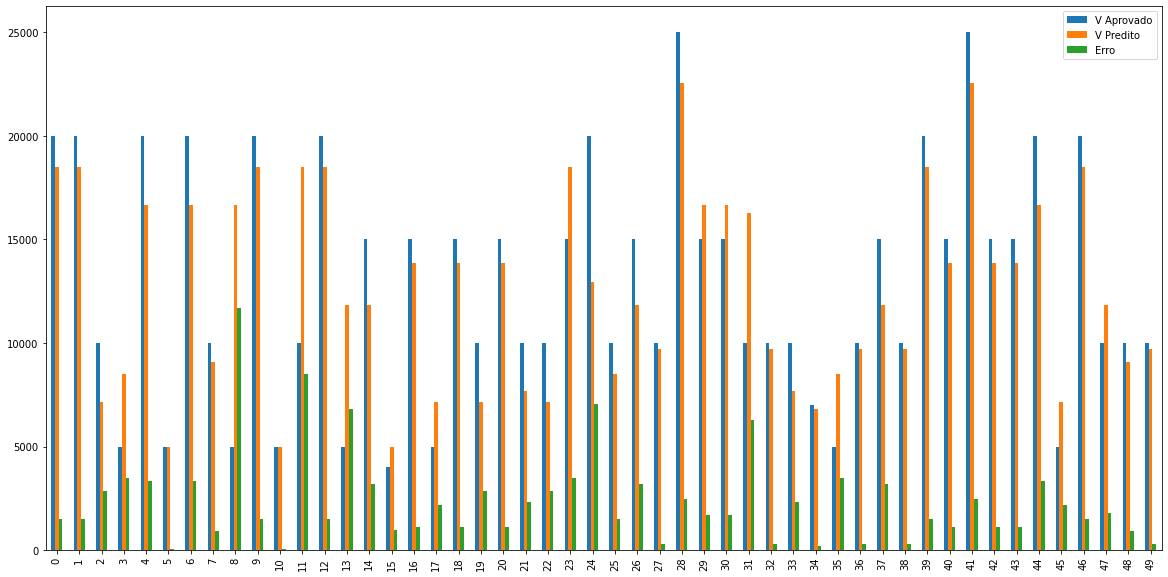

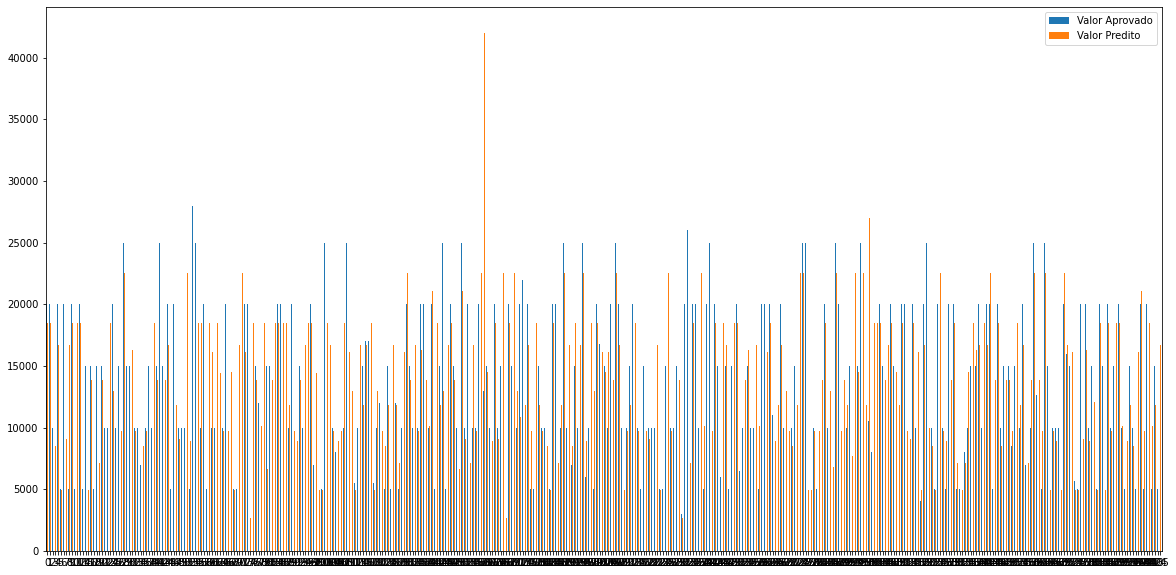

In [14]:

model=classifiers[4]
y_pred = model.predict(X_test)
predictions=y_pred #y_pred[:,0]
predictions=predictions.astype(int)
erros = np.absolute( y_test - predictions)
finalresult = pd.DataFrame({
        "V Aprovado": y_test,
        "V Predito": predictions,
        "Erro" : erros
    })

finalresult.head(50).plot(kind='bar',figsize = (20,10))


dfresult = pd.DataFrame({
        "Valor Aprovado": y_test,
        "Valor Predito": predictions #y_pred[:,0]
    })
dfresult.plot.bar(rot=0, figsize = (20,10))
